In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from scipy.stats import skew
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import os
os.chdir('/Users/liyuan/desktop/SI699/codes')

In [178]:
from data_preprocess import Data_preprocess
from reformat_data_by_day import Reformat_data
from seq2seq import seq2seq
from implement_seq2seq import implement_seq2seq

In [179]:
data_p = Data_preprocess('../expedia_data/train.csv','../expedia_data/test.csv')
all_data = data_p.load_data()
# sampled_data = data_p.sample_data(5000)
# cleaned_sampled_data = data_p.clean_data(sampled_data,'../res/cleaned_sampled_data')

sampled_data = data_p.sample_data(10000)
cleaned_sampled_data = data_p.clean_data(sampled_data,'../res/cleaned_sampled_data_10000')

training data has 9917530 records
test data has 6622629 records
Columns only available in training data: ['position', 'click_bool', 'gross_bookings_usd', 'booking_bool']
Whole dataset has 16540159 records


In [4]:
data_r = Reformat_data()
sampled = data_r.load_data('../res/sampled_data_5000.csv')
categorical_vars,categorical_binary_vars,continuous_vars = data_r.divide_variables()

In [13]:
dest_data_list = data_r.get_data_by_dest()
print('there are %d unique destinations' % len(dest_data_list))
datetime_range = data_r.get_datetime_range()
print('there are %d days'%len(datetime_range))
all_daily_price = data_r.get_all_daily_price()

there are 2247 unique destinations
there are 484 days


/Users/liyuan/Desktop/SI699/codes/reformat_data_by_day.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dest_data['date_time'] = pd.to_datetime(dest_data.date_time)


In [15]:
# all_daily_price

In [153]:
print(list(all_daily_price.keys())[:10])
# sort price data by destination, based on their valid record number
print('sorted list of destinations rankded in desceding of valid record number (top10):')
print(sorted(all_daily_price.keys(), key = lambda x: len(all_daily_price[x].dropna()), reverse = True)[:10])
print('largest number of valid records among all destinations: %d'%len(all_daily_price[8192].dropna()))

[17894, 19274, 4453, 11485, 3404, 11299, 9265, 23904, 24844, 20834]
sorted list of destinations rankded in desceding of valid record number (top10):
[8192, 4562, 10979, 9402, 23904, 13292, 8347, 6948, 13870, 13216]
largest number of valid records among all destinations: 59


In [233]:
ss = seq2seq()
data = ss.load_data('res/price_data_8192.csv')
sequence_list = ss.get_sequence_data()
sequence_list[0]['price'].values

array([ 80.,  nan,  nan,  nan, 299., 215.,  nan])

In [ ]:
# Trial

In [16]:
# TODO: get daily price of entire sampled data
sampled['date_time'] = pd.to_datetime(sampled.date_time)
sampled = sampled.set_index('date_time')
daily_price = sampled['price_usd'].resample('D').median()

In [175]:
daily_price.head()
daily_price.to_csv('../res/daily_price.csv')

In [172]:
import tensorflow as tf 

def load_data(window_size):
    data = pd.read_csv('../res/sampled_data_5000.csv')
    predictor_names = ["price_usd"]
    training_features = np.asarray(data[predictor_names], dtype = "float32")
    kept_values = training_features[100:]

    X = []
    Y = []
    for i in range(len(kept_values) - window_size * 2):#  x ；前window_size，y后window_size
        X.append(kept_values[i:i + window_size])
        Y.append(kept_values[i + window_size:i + window_size * 2])

    X = np.reshape(X,[-1,window_size,len(predictor_names)])
    Y = np.reshape(Y,[-1,window_size,len(predictor_names)])
    print(np.shape(X))
    return X, Y

X, y = load_data(window_size=7)

(4886, 7, 1)


In [173]:
X_train = []
Y_train = []
X_test = []
Y_test = []

def generate_data(isTrain, batch_size):        
    # 40 pas values for encoder, 40 after for decoder's predictions.

    seq_length = 20  
    seq_length_test = 20

    global Y_train
    global X_train
    global X_test
    global Y_test
    # First load, with memoization:
    if len(Y_train) == 0:       
        X, Y= load_data( window_size=seq_length)
        #X, Y = normalizestock(X, Y)

        # Split 80-20:
        X_train = X[:int(len(X) * 0.8)]
        Y_train = Y[:int(len(Y) * 0.8)]


    if len(Y_test) == 0:
        X, Y  = load_data( window_size=seq_length_test)
        #X, Y = normalizestock(X, Y)

        # Split 80-20:
        X_test = X[int(len(X) * 0.8):]
        Y_test = Y[int(len(Y) * 0.8):]

    if isTrain:
        return do_generate_x_y(X_train, Y_train, batch_size)
    else:
        return do_generate_x_y(X_test,  Y_test,  batch_size)

In [174]:
def do_generate_x_y(X, Y, batch_size):
    assert X.shape == Y.shape, (X.shape, Y.shape)
    idxes = np.random.randint(X.shape[0], size=batch_size)
    X_out = np.array(X[idxes]).transpose((1, 0, 2))
    Y_out = np.array(Y[idxes]).transpose((1, 0, 2))
    return X_out, Y_out
    
sample_now, sample_f = generate_data(isTrain=True, batch_size=3)
print("training examples : ")
print(sample_now.shape)
print("(seq_length, batch_size, output_dim)")

seq_length = sample_now.shape[0]
batch_size = 100

output_dim = input_dim = sample_now.shape[-1]
hidden_dim = 12  
layers_num = 2

(4860, 20, 1)
(4860, 20, 1)
training examples : 
(20, 3, 1)
(seq_length, batch_size, output_dim)


In [148]:
# Optmizer:
learning_rate =0.04
nb_iters = 5000
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

In [149]:
tf.reset_default_graph()

encoder_input = []
expected_output = []
decode_input =[]
for i in range(seq_length):
    encoder_input.append( tf.placeholder(tf.float32, shape=( None, input_dim)) )
    expected_output.append( tf.placeholder(tf.float32, shape=( None, output_dim)) )
    decode_input.append( tf.placeholder(tf.float32, shape=( None, input_dim)) )


tcells = []
for i in range(layers_num):
    tcells.append(tf.contrib.rnn.GRUCell(hidden_dim))
Mcell = tf.contrib.rnn.MultiRNNCell(tcells)

dec_outputs, dec_memory = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq(encoder_input,decode_input,Mcell)

reshaped_outputs = []
for ii in dec_outputs :
    reshaped_outputs.append( tf.contrib.layers.fully_connected(ii,output_dim,activation_fn=None))

In [150]:
# L2 loss
output_loss = 0
for _y, _Y in zip(reshaped_outputs, expected_output):
    output_loss += tf.reduce_mean( tf.pow(_y - _Y, 2) )

In [151]:
# generalization capacity)
reg_loss = 0
for tf_var in tf.trainable_variables():
    if not ("fully_connected" in tf_var.name ):
        #print(tf_var.name)
        reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

loss = output_loss + lambda_l2_reg * reg_loss
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)   

sess = tf.InteractiveSession()

/anaconda3/envs/leetcode/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [152]:
def train_batch(batch_size):
    X, Y = generate_data(isTrain=True, batch_size=batch_size)
    feed_dict = {encoder_input[t]: X[t] for t in range(len(encoder_input))}
    feed_dict.update({expected_output[t]: Y[t] for t in range(len(expected_output))})

    c =np.concatenate(( [np.zeros_like(Y[0])],Y[:-1]),axis = 0)

    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})

    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t

In [153]:
def test_batch(batch_size):
    X, Y = generate_data(isTrain=True, batch_size=batch_size)
    feed_dict = {encoder_input[t]: X[t] for t in range(len(encoder_input))}
    feed_dict.update({expected_output[t]: Y[t] for t in range(len(expected_output))})
    c =np.concatenate(( [np.zeros_like(Y[0])],Y[:-1]),axis = 0)#来预测最后一个序列
    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})    
    output_lossv,reg_lossv,loss_t = sess.run([output_loss,reg_loss,loss], feed_dict)
    print("-----------------")    
    print(output_lossv,reg_lossv)
    return loss_t


In [154]:
# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters + 1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)
    if t % 50 == 0:
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t,nb_iters, train_loss, test_loss))
print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))

-----------------
837045.7 117.72473
Step 0/5000, train loss: 987017.1875, 	TEST loss: 837046.0625
-----------------
708323.25 280.89447
Step 50/5000, train loss: 683815.1875, 	TEST loss: 708324.0625
-----------------
751810.7 291.48508
Step 100/5000, train loss: 671307.1875, 	TEST loss: 751811.5625
-----------------
578679.7 295.90604
Step 150/5000, train loss: 473678.96875, 	TEST loss: 578680.5625
-----------------
463999.47 306.16574
Step 200/5000, train loss: 334629.0, 	TEST loss: 464000.375
-----------------
330593.97 317.76706
Step 250/5000, train loss: 436250.625, 	TEST loss: 330594.9375
-----------------
551728.9 351.95682
Step 300/5000, train loss: 469449.625, 	TEST loss: 551729.9375
-----------------
338447.47 354.2145
Step 350/5000, train loss: 388729.03125, 	TEST loss: 338448.53125
-----------------
445137.62 362.31348
Step 400/5000, train loss: 324741.75, 	TEST loss: 445138.71875
-----------------
241084.6 366.83722
Step 450/5000, train loss: 338885.15625, 	TEST loss: 2410

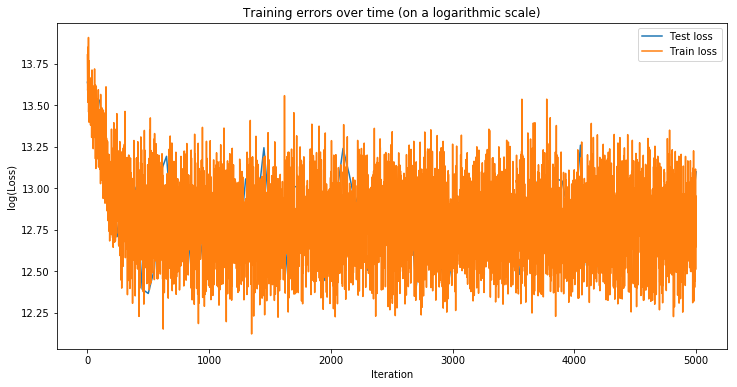

In [155]:
# Plot loss over time:
plt.figure(figsize=(12, 6))
plt.plot(np.array(range(0, len(test_losses))) /
    float(len(test_losses) - 1) * (len(train_losses) - 1),
    np.log(test_losses),label="Test loss")
    
plt.plot(np.log(train_losses),label="Train loss")
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()   

In [158]:
expected_output

[<tf.Tensor 'Placeholder_1:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_4:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_7:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_10:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_13:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_16:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_19:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_22:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_25:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_28:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_31:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_34:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_37:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_40:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_43:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_46:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_49:0' shape=(?, 1)

In [171]:
# Test
nb_predictions = 5
print("visualize {} predictions data:".format(nb_predictions))

preout =[]
X, Y = generate_data(isTrain=False, batch_size=nb_predictions)
print(np.shape(X),np.shape(Y))
for tt in  range(seq_length):
    feed_dict = {encoder_input[t]: X[t+tt] for t in range(seq_length)}
    feed_dict.update({expected_output[t]: Y[t+tt] for t in range(len(expected_output))})
    c =np.concatenate(( [np.zeros_like(Y[0])],Y[tt:seq_length+tt-1]),axis = 0)  #从前15个的最后一个开始预测  

    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})
    outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])
    print(outputs)
    preout.append(outputs[-1])

print(np.shape(preout)) #将每个未知预测值收集起来准备显示出来。
preout =np.reshape(preout,[seq_length,nb_predictions,output_dim])

visualize 5 predictions data:
(20, 5, 1) (20, 5, 1)
[[[154.28278]
  [154.28278]
  [154.28275]
  [154.28278]
  [154.28278]]

 [[151.42538]
  [151.42609]
  [151.42607]
  [151.42607]
  [151.42606]]

 [[153.41255]
  [153.41255]
  [153.41252]
  [153.41254]
  [153.41255]]

 [[154.75876]
  [154.75874]
  [154.75873]
  [154.75873]
  [154.75876]]

 [[155.04471]
  [155.04471]
  [155.04471]
  [155.0447 ]
  [155.04471]]

 [[154.32991]
  [154.32991]
  [154.32986]
  [154.3299 ]
  [154.3299 ]]

 [[154.57318]
  [154.57318]
  [154.57317]
  [154.57317]
  [154.57318]]

 [[154.3047 ]
  [154.3047 ]
  [154.30469]
  [154.30469]
  [154.3047 ]]

 [[159.04953]
  [159.04953]
  [159.0495 ]
  [159.04953]
  [159.04953]]

 [[152.81085]
  [152.81084]
  [152.81082]
  [152.81082]
  [152.81084]]

 [[153.56477]
  [153.56476]
  [153.56474]
  [153.56476]
  [153.56477]]

 [[158.36551]
  [158.3655 ]
  [158.3655 ]
  [158.3655 ]
  [158.36551]]

 [[159.7224 ]
  [159.72238]
  [159.72237]
  [159.72237]
  [159.72238]]

 [[155.66556

IndexError: index 20 is out of bounds for axis 0 with size 20

In [139]:
for j in range(nb_predictions):
    plt.figure(figsize=(12, 3))

    for k in range(output_dim):
        past = X[:, j, k]
        expected = Y[seq_length-1:, j, k]#对应预测值的打印

        pred = preout[:, j, k]

        label1 = "past" if k == 0 else "_nolegend_"
        label2 = "future" if k == 0 else "_nolegend_"
        label3 = "Pred" if k == 0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)
        plt.plot(range(len(past), len(expected) + len(past)),
                 expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred) + len(past)),
                 pred, "o--y", label=label3)

    plt.legend(loc='best')
    plt.title("Predictions vs. future")
    plt.show()

TypeError: list indices must be integers or slices, not tuple

<Figure size 864x216 with 0 Axes>

In [10]:
sampled.columns.unique().tolist()
data_r.variables

['srch_id',
 'site_id',
 'visitor_location_country_id',
 'visitor_hist_starrating',
 'visitor_hist_adr_usd',
 'prop_country_id',
 'prop_id',
 'prop_starrating',
 'prop_review_score',
 'prop_brand_bool',
 'prop_location_score1',
 'prop_location_score2',
 'prop_log_historical_price',
 'promotion_flag',
 'srch_destination_id',
 'srch_length_of_stay',
 'srch_booking_window',
 'srch_adults_count',
 'srch_children_count',
 'srch_room_count',
 'srch_saturday_night_bool',
 'srch_query_affinity_score',
 'orig_destination_distance',
 'random_bool',
 'comp1_rate',
 'comp1_inv',
 'comp1_rate_percent_diff',
 'comp2_rate',
 'comp2_inv',
 'comp2_rate_percent_diff',
 'comp3_rate',
 'comp3_inv',
 'comp3_rate_percent_diff',
 'comp4_rate',
 'comp4_inv',
 'comp4_rate_percent_diff',
 'comp5_rate',
 'comp5_inv',
 'comp5_rate_percent_diff',
 'comp6_rate',
 'comp6_inv',
 'comp6_rate_percent_diff',
 'comp7_rate',
 'comp7_inv',
 'comp7_rate_percent_diff',
 'comp8_rate',
 'comp8_inv',
 'comp8_rate_percent_diff',